https://droit-finances.commentcamarche.com/justice/guide-justice/4485-code-civil/

In [ ]:
# Librairies de traitement de texte et PDF
!pip install -q sentence-transformers pdfplumber pandas numpy scikit-learn matplotlib networkx tqdm

# Librairies pour FAISS et vectorisation
!pip install langchain langchain-community langchain_huggingface

# Transformers et HuggingFace
!pip install transformers huggingface-hub accelerate bitsandbytes

# Pour les variables d'environnement
!pip install -q python-dotenv

# Google GenAI
!pip install -q google-genai

# Affichage dans Jupyter
!pip install ipython

!pip install faiss-cpu


# Import

In [ ]:
from sentence_transformers import SentenceTransformer
import pdfplumber
import os
import faiss
import matplotlib.pyplot as plt
import random
import time
import pandas as pd
import numpy as np
import re


import networkx as nx

from IPython.display import display, Markdown
from sklearn.metrics.pairwise import cosine_similarity, linear_kernel


from huggingface_hub import login
from transformers import AutoTokenizer, AutoModelForCausalLM
from transformers import BitsAndBytesConfig
import google.genai as genai
from dotenv import load_dotenv


from typing import TypedDict, List

from langchain_community.vectorstores import FAISS
from langchain_core.documents import Document
from langchain_huggingface import HuggingFaceEmbeddings


from langgraph.graph import StateGraph


from tqdm.notebook import trange, tqdm
from collections import Counter

load_dotenv()


True

In [5]:
import torch
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


False
No GPU


### Gemini

In [57]:


client = genai.Client(api_key=os.getenv("GEMINI_API_KEY"))

def generate_answer(final_prompt: str) -> str:
    response = client.models.generate_content(
        model="gemini-2.5-flash-lite",
        contents=final_prompt
    )
    return response.text


In [12]:
model = SentenceTransformer('all-MiniLM-L6-v2', device='cuda' if torch.cuda.is_available() else 'cpu')

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

# DATA SET

Le Code civil est un code juridique regroupant les règles du droit français relatives au statut des personnes (livre Ier), à celui des biens (livre II) et à celui des relations entre les personnes privées (livres III et IV). Promulgué en 1804, le Code civil est également appelé " Code Napoléon ". Ce fichier comprend les articles du Code civil de l'article 1 à l'article 2534. Il traite notamment des règles légales applicables à la succession, aux régimes matrimoniaux, au Pacs, au divorce, à l'usufruit, aux sociétés civiles immobilières (SCI), aux relations de voisinage, au changement de nom de famille, etc.

In [13]:
def extract_text_from_pdfs(folder_path):
    documents = []
    for filename in os.listdir(folder_path):
        if filename.endswith(".pdf"):
            path = os.path.join(folder_path, filename)
            text = ""
            with pdfplumber.open(path) as pdf:
                for page in pdf.pages:
                    text += page.extract_text() + "\n"
            documents.append((filename, text))
    return documents

papers = extract_text_from_pdfs("./codecivil")
print(len(papers))

1


In [14]:
# delete useless footer
texts = papers[0][1].replace("Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025", "")

le pdf que nous avons choisi est le code Civil, comme dis précédemment. Il rangé sous cette forme :

il y a 4 livres, dans ces livres il y a des titres, dans ces titres il y a des chapitres et dans ces articles parfois il y a des sections et dans ces sections parfois il y a des paragraphes et des sous-sections.  


On part du postulat que les articles de loi sont dépendants, mais que de textes proche d'eux meme. 
Articles 2372-5 cite l'article 2372-1 pas l'Article 900-5


Cette <b>regex</b> détecte les titres de type “Article X”
- lorsqu’ils apparaissent en début de ligne.
- elle capture tout ce qui suit sur la même ligne jusqu’au retour à la ligne (\n). (solide pour les article additionnel : article 2488-1)

In [15]:
def extract_articles(text):
    parts = re.split(r'(Article\s\d+[^\n]*)', text)
    articles = []
    for i in range(1, len(parts), 2):
        title = parts[i].strip()
        content = parts[i + 1].strip()
        articles.append({"title": title, "content": content})
    return articles

all_articles = []
for filename, text in papers:
    articles = extract_articles(text)
    for article in articles:
        all_articles.append({"filename": filename, "title": article["title"], "content": article["content"]})

lengths = [len(article["content"].split()) for article in all_articles]
print(f"Nombre total d'articles extraits : {len(all_articles)}")
print(f"Longueur moyenne des articles : {np.mean(lengths)} mots")
print(("\n\n"))
#print(all_articles[0]["content"])

Nombre total d'articles extraits : 2890
Longueur moyenne des articles : 68.09307958477508 mots





le dernier artcile est le 2490 mais nous comptons aussi les articles additionnel ce qui nous fait 2890 artcile.


### Exemple 

In [16]:
# trouve l'article 2488
for article in all_articles:
    if "Article 2488-1" in article["title"]:
        print(article["title"])
        print(article["content"])

        print(("\n\n"))

Article 2488-1
La propriété d'un bien immobilier peut être cédée à titre de garantie d'une obligation en vertu d'un contrat de
fiducie conclu en application des articles 2011 à 2030.
L'obligation garantie peut être présente ou future ; dans ce dernier cas, elle doit être déterminable.
Par dérogation à l'article 2029, le décès du constituant personne physique ne met pas fin au contrat de fiducie
constitué en application du présent chapitre.
Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025



Article 2488-10
Les droits et biens acquis par l'agent des sûretés dans l'exercice de sa mission ne peuvent être saisis que par
les titulaires de créances nées de leur conservation ou de leur gestion, sous réserve de l'exercice d'un droit de
suite et hors les cas de fraude.
L'ouverture d'une procédure de sauvegarde, de redressement judiciaire, de liquidation judiciaire, de
rétablissement professionnel, de surendettement ou de résolution bancaire à l'égard 

# RAG

Première étape, faire un RAG classique

- faire des chunks  
On coupe le texte dans par chunk de 450 mots (soit 7 articles) pour avoir du contexte sur les artciles précédent et ultérieur 
- index faiss

## Chunk

In [17]:
def chunk_text(text, chunk_size=500, overlap=50):
    words = text.split()
    chunks = []
    for i in range(0, len(words), chunk_size - overlap):
        chunk = " ".join(words[i:i + chunk_size])
        chunks.append(chunk)
    return chunks

texts = []
metadata = []

for filename, content in papers:
    chunks = chunk_text(content)
    for i, chunk in enumerate(chunks):
        texts.append(chunk)
        metadata.append({"source": filename, "chunk": i})


In [18]:
print(len(chunks))
print(chunks[1])

451
subi, prescrire toutes mesures, telles que séquestre, saisie et autres, propres à empêcher ou faire cesser une atteinte à l'intimité de la vie privée : ces mesures peuvent, s'il y a urgence, être ordonnées en référé. Article 9-1 Chacun a droit au respect de la présomption d'innocence. Lorsqu'une personne est, avant toute condamnation, présentée publiquement comme étant coupable de faits faisant l'objet d'une enquête ou d'une instruction judiciaire, le juge peut, même en référé, sans préjudice de la réparation du dommage subi, prescrire toutes mesures, telles que l'insertion d'une rectification ou la diffusion d'un communiqué, aux fins de faire cesser l'atteinte à la présomption d'innocence, et ce aux frais de la personne, physique ou morale, responsable de cette atteinte. Article 10 Code civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025 Chacun est tenu d'apporter son concours à la justice en vue de la manifestation de la vérité. Celui qui, sans

Nous avons rajouté un batch size, pour amélioré la vitesse et remplir la ram du gpu a son maxium 

In [ ]:

def get_embedding(text):
    return model.encode(text)

batch_size = 32
all_embeddings = []

for i in trange(0, len(texts), batch_size, desc="Encoding texts"):
    batch = texts[i: i+batch_size]
    emb = model.encode(batch, show_progress_bar=False)
    all_embeddings.append(emb)

embeddings = np.vstack(all_embeddings).astype("float32")


Encoding texts:   0%|          | 0/15 [00:00<?, ?it/s]

In [25]:
print(embeddings[5].size)

384


In [26]:
index = faiss.IndexFlatL2(embeddings.shape[1])
index.add(embeddings)
print(f"FAISS index crée avec {index.ntotal} chunks.") 

FAISS index crée avec 451 chunks.


In [27]:
def search(query, k=4):
    query_embed = np.array(get_embedding(query)).astype("float32")
    D, I = index.search(np.array([query_embed]), k)
    return [(texts[i], metadata[i]) for i in I[0]]

In [28]:
search("Est-ce que la vente parfaite implique que celui qui s’est déjà engagé ne peut vendre au plus offrant ?")


[("la dette garantie, une somme égale à la différence entre cette valeur et le montant de la dette, sous réserve du paiement préalable des dettes nées de la conservation ou de la gestion du patrimoine fiduciaire. Sous la même réserve, si le fiduciaire procède à la vente du bien ou du droit cédé en application du contrat de fiducie, il restitue au constituant la part du produit de cette vente excédant, le cas échéant, la valeur de la dette garantie. Article 2372-5 La propriété cédée en application de l'article 2372-1 peut être ultérieurement affectée à la garantie de dettes autres que celles mentionnées par l'acte constitutif pourvu que celui-ci le prévoie expressément. Le constituant peut l'offrir en garantie, non seulement au créancier originaire, mais aussi à un nouveau créancier, encore que le premier n'ait pas été payé. Lorsque le constituant est une personne physique, le patrimoine fiduciaire ne peut alors être affecté en garantie d'une nouvelle dette que dans la limite de sa vale

In [ ]:
def ask(query):
    results = search(query)
    context = "\n---\n".join([f"{meta['source']} [chunk {meta['chunk']}]:\n{text}" for text, meta in results])
    prompt = f"Tu es un assistant juridique. Utilise le contexte ci-dessous pour répondre à la question.\n\nContexte:\n{context}\n\nQuestion: {query}\nRéponse:"
    
    answer = generate_answer(prompt)

    display(Markdown(f"**Question:** {query}"))
    display(Markdown(f"**Réponse :**\n{answer}"))
    display(Markdown("**Sources :**"))
    for text, meta in results:
        display(Markdown(f"- `{meta['source']} {text} [chunk {meta['chunk']}]`"))

ask("Est-ce que la vente parfaite implique que celui qui s’est déjà engagé ne peut vendre au plus offrant ?")

# Embedding

## Création data set
  
on créé un dataset de 50 questions pour trouver l'embedding fontionnant le mieux pour ce document.
On crée un CSV contenant les 50 chunks avec pour chaque chunk une question associée
et ainsi trouvé quel embedding rapproche le plus la question du chunk associé.


In [12]:
import pandas as pd
df1 = pd.read_csv("q&a_pair_par_chunk.csv")
df2 = pd.read_csv("q&a_pair_par_chunk2.csv")

df1_good = df1[(df1["chunk_id"] >= 1) & (df1["chunk_id"] < 20)]
df2_good = df2[(df2["chunk_id"] >= 20) & (df2["chunk_id"] <= 50)]

# Fusion (empilement vertical)
df_final = pd.concat([df1_good, df2_good], ignore_index=True)
df_final.to_csv("q&a_pair_par_chunk_final.csv", index=False)

In [ ]:
sampled_chunks = random.sample(chunks, 50)
results = []

for i, chunk in enumerate(sampled_chunks):
    prompt = f"Génère une question factuelle dont la réponse se trouve dans ce contexte:\n\n{chunk}"

    try:
        time.sleep(5)
        question = generate_answer(prompt)
        results.append({"chunk_id": i, "chunk": chunk, "question": question})
        print(f"[{i+1}/50] Question généré.")
        time.sleep(0.1)

    except Exception as e:
        print(f"[{i+1}/50] ❌ Error: {e}")
        results.append({"chunk_id": i, "chunk": chunk, "question": None})
        time.sleep(2)

df = pd.DataFrame(results)
df.to_csv("q&a_pair_par_chunk.csv", index=False)

[1/50] Question généré.
[2/50] Question généré.
[3/50] Question généré.
[4/50] Question généré.
[5/50] Question généré.
[6/50] Question généré.
[7/50] Question généré.
[8/50] Question généré.
[9/50] Question généré.
[10/50] Question généré.
[11/50] ❌ Error: 429 RESOURCE_EXHAUSTED. {'error': {'code': 429, 'message': 'You exceeded your current quota, please check your plan and billing details. For more information on this error, head to: https://ai.google.dev/gemini-api/docs/rate-limits. To monitor your current usage, head to: https://ai.dev/usage?tab=rate-limit. \n* Quota exceeded for metric: generativelanguage.googleapis.com/generate_content_free_tier_requests, limit: 10, model: gemini-2.5-flash-lite\nPlease retry in 2.448730379s.', 'status': 'RESOURCE_EXHAUSTED', 'details': [{'@type': 'type.googleapis.com/google.rpc.Help', 'links': [{'description': 'Learn more about Gemini API quotas', 'url': 'https://ai.google.dev/gemini-api/docs/rate-limits'}]}, {'@type': 'type.googleapis.com/google

KeyboardInterrupt: 

In [ ]:
file_path = "q&a_pair_par_chunk.csv"
df = pd.read_csv(file_path)
print(df.head())
chunks = df['chunk'].tolist()
queries = df['question'].tolist()
ground_truth = df['chunk_id'].tolist()


   chunk_id                                              chunk  \
0         0  dans lesquelles il se poursuit. Sous la même r...   
1         1  ou par décision unilatérale. La formalité de s...   
2         2  et lui payer ses salaires lorsqu'il en a été p...   
3         3  non, même avec reconnaissance d'écriture et de...   
4         4  chose emporte obligation de la conserver jusqu...   

                                            question  
0  Quelles sont les conditions pour qu'une transa...  
1  Quelles sont les conditions dans lesquelles le...  
2  Quelles sont les différentes manières dont le ...  
3  Quelles sont les formalités de publicité fonci...  
4  Quels sont les effets du contrat à l'égard des...  


### Choix de l'embedding

| Nom      | Modèle réel                             | Commentaire                                                                         |
| -------- | --------------------------------------- | ----------------------------------------------------------------------------------- |
| MiniLM   | sentence-transformers/all-MiniLM-L6-v2  |  Très rapide, léger, bonne qualité.                                                  |
| E5-Base  | intfloat/e5-base-v2                     | Optimisé pour retrieval, excellent rapport vitesse/qualité.                         |
| BGE-Base | BAAI/bge-base-en                        | Très bon pour la recherche dense. Pré-instructions dans les prompts ("query: ..."). |
| Fr-doc   | dangvantuan/french-document-embedding   | Embedding spécialisé français.                                                      |
| MPNet    | sentence-transformers/all-mpnet-base-v2 | Un des meilleurs généralistes SBERT.                                                |
| Jina Embeddings v3 | jinaai/jina-embeddings-v3     | Optimisé pour la sémantique longue distance                                                |


In [ ]:
model_names = {
    "MiniLM": "sentence-transformers/all-MiniLM-L6-v2",
    "E5-Base": "intfloat/e5-base-v2",
    "BGE-Base": "BAAI/bge-base-en",
    "Fr-doc": "dangvantuan/french-document-embedding",
    "MPNet": "all-mpnet-base-v2",
    "Jina-Embeddings-v3": "jinaai/jina-embeddings-v3"
}
def cosine_sim(a, b):
    return cosine_similarity(a, b)

def dot_sim(a, b):
    return np.dot(a, b.T)

def inner_sim(a, b):
    return linear_kernel(a, b)

similarity_functions = {
    "cosine": cosine_sim,
    "dot": dot_sim,
    "inner": inner_sim
}


c:\Users\thoma\AppData\Local\Programs\Python\Python313\Lib\site-packages\huggingface_hub\file_download.py:140: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\thoma\.cache\huggingface\hub\models--sentence-transformers--all-mpnet-base-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


   embedding_model similarity  accuracy@5  precision@1     MRR  Avg_Rank
0           MiniLM     cosine        70.0         58.0  0.6447      6.58
1           MiniLM        dot        70.0         58.0  0.6447      6.58
2           MiniLM      inner        70.0         58.0  0.6447      6.58
3          E5-Base     cosine        96.0         64.0  0.7668      2.32
4          E5-Base        dot        96.0         64.0  0.7668      2.32
5          E5-Base      inner        96.0         64.0  0.7668      2.32
6         BGE-Base     cosine        80.0         60.0  0.6889      4.72
7         BGE-Base        dot        80.0         60.0  0.6889      4.72
8         BGE-Base      inner        80.0         60.0  0.6889      4.72
9           Fr-doc     cosine        98.0         90.0  0.9415      1.32
10          Fr-doc        dot        98.0         90.0  0.9415      1.32
11          Fr-doc      inner        98.0         90.0  0.9415      1.32
12           MPNet     cosine        82.0         5

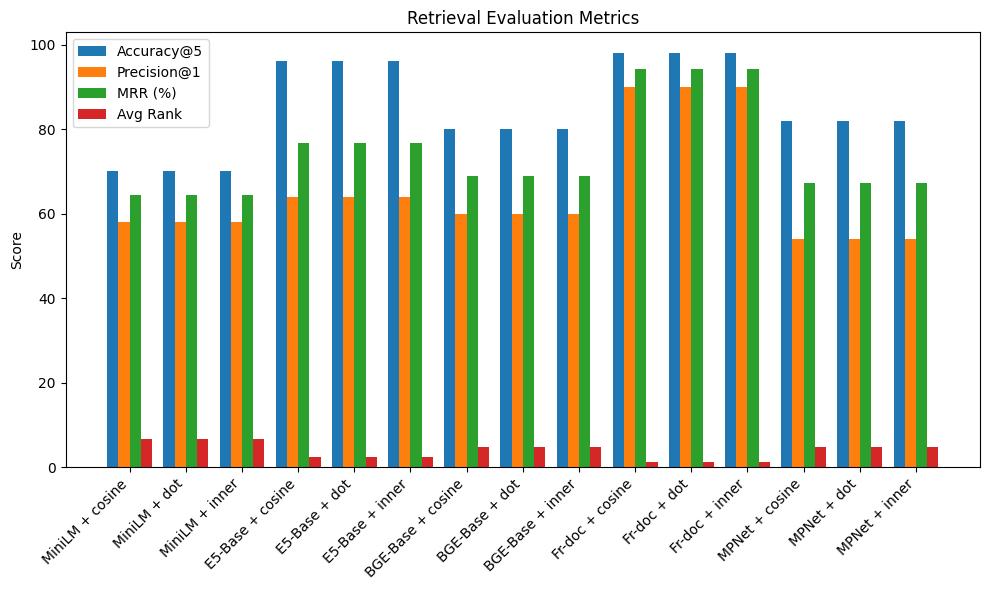

In [ ]:
results = []

for model_label, model_path in model_names.items():
    model = SentenceTransformer(model_path,trust_remote_code=True)
    chunk_vecs = model.encode(chunks, normalize_embeddings=True)
    query_vecs = model.encode(queries, normalize_embeddings=True)

    for sim_label, sim_fn in similarity_functions.items():
        sim_matrix = sim_fn(query_vecs, chunk_vecs)

        k = 4
        top_k_hits = []
        top1_hits = []
        reciprocal_ranks = []
        ranks = []

        for i, scores in enumerate(sim_matrix):
            ranking = np.argsort(scores)[::-1]
            top_k_indices = ranking[:k]
            correct_idx = ground_truth[i]
            top_k_hits.append(correct_idx in top_k_indices)
            top1_hits.append(correct_idx == ranking[0])
            if correct_idx in ranking:
                rank = np.where(ranking == correct_idx)[0][0] + 1
                reciprocal_ranks.append(1.0 / rank)
                ranks.append(rank)
            else:
                reciprocal_ranks.append(0.0)
                ranks.append(len(ranking) + 1)

        results.append({
            "embedding_model": model_label,
            "similarity": sim_label,
            f"accuracy@{k}": round(np.mean(top_k_hits) * 100, 2),
            "precision@1": round(np.mean(top1_hits) * 100, 2),
            "MRR": round(np.mean(reciprocal_ranks), 4),
            "Avg_Rank": round(np.mean(ranks), 2)
        })

results_df = pd.DataFrame(results)
print(results_df)

fig, ax = plt.subplots(figsize=(10, 6))
x = np.arange(len(results_df))
width = 0.2

ax.bar(x - 1.5*width, results_df[f"accuracy@{k}"], width, label=f'Accuracy@{k}')
ax.bar(x - 0.5*width, results_df["precision@1"], width, label='Precision@1')
ax.bar(x + 0.5*width, results_df["MRR"] * 100, width, label='MRR (%)')
ax.bar(x + 1.5*width, results_df["Avg_Rank"], width, label='Avg Rank')

ax.set_xticks(x)
ax.set_xticklabels(results_df["embedding_model"] + " + " + results_df["similarity"], rotation=45, ha='right')
ax.set_ylabel("Score")
ax.set_title("Retrieval Evaluation Metrics")
ax.legend()
plt.tight_layout()
plt.show()

# Graph Rag

In [ ]:
print(all_articles)
print(len(all_articles))
print(all_articles[137])

2890
{'title': 'Article 30-4', 'content': "En dehors des cas de perte ou de déchéance de la nationalité française, la preuve de l'extranéité d'un individu\npeut seulement être établie en démontrant que l'intéressé ne remplit aucune des conditions exigées par la loi\npour avoir la qualité de Français.\nCode civil - Dernière modification le 14 septembre 2024 - Document généré le 10 février 2025\nSection 3 : Des certificats de nationalité française"}


In [ ]:
embedder = SentenceTransformer('dangvantuan/french-document-embedding',trust_remote_code=True)  


def embed_articles(all_articles):
    texts = [a['content'] for a in all_articles]
    embeddings = embedder.encode(texts, show_progress_bar=True)
    return embeddings


def embed_articles_batch(all_articles, batch_size=64):
    texts = [a['content'] for a in all_articles]
    all_embeddings = []
    for i in trange(0, len(texts), batch_size, desc="Encoding articles"):
        batch = texts[i : i+batch_size]
        emb = embedder.encode(batch, show_progress_bar=False)
        all_embeddings.append(emb)
    embeddings = np.vstack(all_embeddings)
    return embeddings

modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/171 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json: 0.00B [00:00, ?B/s]

configuration.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dangvantuan/bilingual_impl:
- configuration.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


modelling.py: 0.00B [00:00, ?B/s]

A new version of the following files was downloaded from https://huggingface.co/dangvantuan/bilingual_impl:
- modelling.py
. Make sure to double-check they do not contain any added malicious code. To avoid downloading new versions of the code file, you can pin a revision.


model.safetensors:   0%|          | 0.00/1.22G [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

tokenizer.json:   0%|          | 0.00/17.1M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/964 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/296 [00:00<?, ?B/s]

In [ ]:
embeddings = embed_articles(all_articles)

Batches:   0%|          | 0/91 [00:00<?, ?it/s]

In [ ]:
def build_faiss_index(embeddings):
    dim = embeddings[0].shape[0]
    index = faiss.IndexFlatL2(dim)
    index.add(np.array(embeddings))
    return index

index = build_faiss_index(embeddings)

In [ ]:
def build_graph(all_articles):
    G = nx.DiGraph()
    for article in all_articles:
        G.add_node(article['title'], content=article['content'])
    for a1 in all_articles:
        for a2 in all_articles:
            if a2['title'] in a1['content']:
                G.add_edge(a1['title'], a2['title'])
    return G

G = build_graph(all_articles)

In [ ]:
def evaluate_graph_structure(G):

    stats = {
        "nodes": len(G.nodes),
        "edges": len(G.edges),
        "density": nx.density(G),
        "is_connected": nx.is_connected(G.to_undirected()),
        "components": nx.number_connected_components(G.to_undirected()),
        "relation_distribution": Counter(nx.get_edge_attributes(G, "relation").values())
    }
    return stats

evaluate_graph_structure(G)

### Ajout des cross references entre articles

In [ ]:
def enrich_with_cross_references(G, all_articles):
    article_titles = [a["title"] for a in all_articles]
    
    for a in tqdm(all_articles):
        source = a["title"]
        for title in article_titles:
            if title == source:
                continue
            pattern = r"\b" + re.escape(title) + r"\b"
            if re.search(pattern, a["content"], flags=re.IGNORECASE):
                G.add_edge(source, title, relation="cite")


enrich_with_cross_references(G,all_articles)

  0%|          | 0/2890 [00:00<?, ?it/s]

In [43]:
evaluate_graph_structure(G)

{'nodes': 2890,
 'edges': 746,
 'density': 8.934977081664013e-05,
 'is_connected': False,
 'components': 2282,
 'relation_distribution': Counter({'cite': 746})}

### Ajouter des super-nœuds pour les structures légales : Livre, Titre, Chapitre, et relier les articles.

In [ ]:
def add_structure_nodes(G, all_articles):
    for art in all_articles:
        structure = re.findall(r"Livre [IVX]+|Titre [\w\s]+|Chapitre [\w\d]+", art['content'])
        for node in structure:
            if not G.has_node(node):
                G.add_node(node, type="structure")
            G.add_edge(node, art['title'], relation="contient")
            
add_structure_nodes(G,all_articles)

In [45]:
evaluate_graph_structure(G)

{'nodes': 2929,
 'edges': 1008,
 'density': 0.00011753577845065456,
 'is_connected': False,
 'components': 2115,
 'relation_distribution': Counter({'cite': 746, 'contient': 262})}

### Relier les articles sémantiquement proches (ex. deux articles sur les droits de la personne).

In [ ]:
def enrich_with_semantic_similarity(G, all_articles, embeddings, threshold=0.82):
    sim_matrix = cosine_similarity(embeddings)
    for i in range(len(all_articles)):
        for j in range(i+1, len(all_articles)):
            if sim_matrix[i][j] >= threshold:
                G.add_edge(all_articles[i]["title"], all_articles[j]["title"], relation="similaire", weight=sim_matrix[i][j])

enrich_with_semantic_similarity(G,all_articles,embeddings)

In [47]:
evaluate_graph_structure(G)

{'nodes': 2929,
 'edges': 9000,
 'density': 0.0010494265933094157,
 'is_connected': False,
 'components': 519,
 'relation_distribution': Counter({'similaire': 8042,
          'cite': 696,
          'contient': 262})}

In [ ]:
def retrieve_similar(query, embedder, index, all_articles, k=5):
    query_vec = embedder.encode([query])
    D, I = index.search(np.array(query_vec), k)
    return [all_articles[i] for i in I[0]]

relevant_docs = retrieve_similar("Qu’est-ce qu’un contrat synallagmatique ?", embedder, index, all_articles)

In [50]:
print(relevant_docs)

[{'title': 'Article 1106', 'content': "Le contrat est synallagmatique lorsque les contractants s'obligent réciproquement les uns envers les autres.\nIl est unilatéral lorsqu'une ou plusieurs personnes s'obligent envers une ou plusieurs autres sans qu'il y ait\nd'engagement réciproque de celles-ci."}, {'title': 'Article 1168', 'content': "Dans les contrats synallagmatiques, le défaut d'équivalence des prestations n'est pas une cause de nullité du\ncontrat, à moins que la loi n'en dispose autrement."}, {'title': 'Article 1375', 'content': "L'acte sous signature privée qui constate un contrat synallagmatique ne fait preuve que s'il a été fait en\nautant d'originaux qu'il y a de parties ayant un intérêt distinct, à moins que les parties ne soient convenues de\nremettre à un tiers l'unique exemplaire dressé.\nChaque original doit mentionner le nombre des originaux qui en ont été faits.\nCelui qui a exécuté le contrat, même partiellement, ne peut opposer le défaut de la pluralité d'originaux

In [ ]:
def generate_answer2(question, retrieved_docs):
    context = "\n\n".join([f"{doc['title']}: {doc['content']}" for doc in retrieved_docs])
    prompt = f"Réponds à la question suivante selon les extraits de code civil :\n\n{context}\n\nQuestion: {question}\nRéponse:"
    
    answer = generate_answer(prompt)

    display(Markdown(f"**Question:** {question}"))
    display(Markdown(f"**Réponse :**\n{answer}"))
    display(Markdown("**Sources:**"))
    for doc in retrieved_docs:
        display(Markdown(f"{doc['title']}: {doc['content']}"))
    return answer


response = generate_answer2("Qu’est-ce qu’un contrat synallagmatique ?", relevant_docs)


In [59]:
def get_subgraph_for_article(G, article_title, depth=1):
    visited = set([article_title])
    frontier = set([article_title])

    for _ in range(depth):
        next_frontier = set()
        for node in frontier:
            next_frontier.update(G.successors(node))     
            next_frontier.update(G.predecessors(node))    
        frontier = next_frontier - visited
        visited.update(frontier)

    subG = G.subgraph(visited).copy()
    return subG


In [60]:
def visualize_article_graph(G, article_title, depth=1):
    subG = get_subgraph_for_article(G, article_title, depth=depth)

    pos = nx.spring_layout(subG, seed=42)
    plt.figure(figsize=(10, 7))
    
    edge_labels = nx.get_edge_attributes(subG, 'relation')
    node_colors = ['red' if n == article_title else 'skyblue' for n in subG.nodes]
    
    nx.draw(subG, pos, with_labels=True, node_color=node_colors, node_size=1500, font_size=10, arrows=True)
    nx.draw_networkx_edge_labels(subG, pos, edge_labels=edge_labels, font_color='gray')

    plt.title(f"Graphe centré sur {article_title}")
    plt.show()


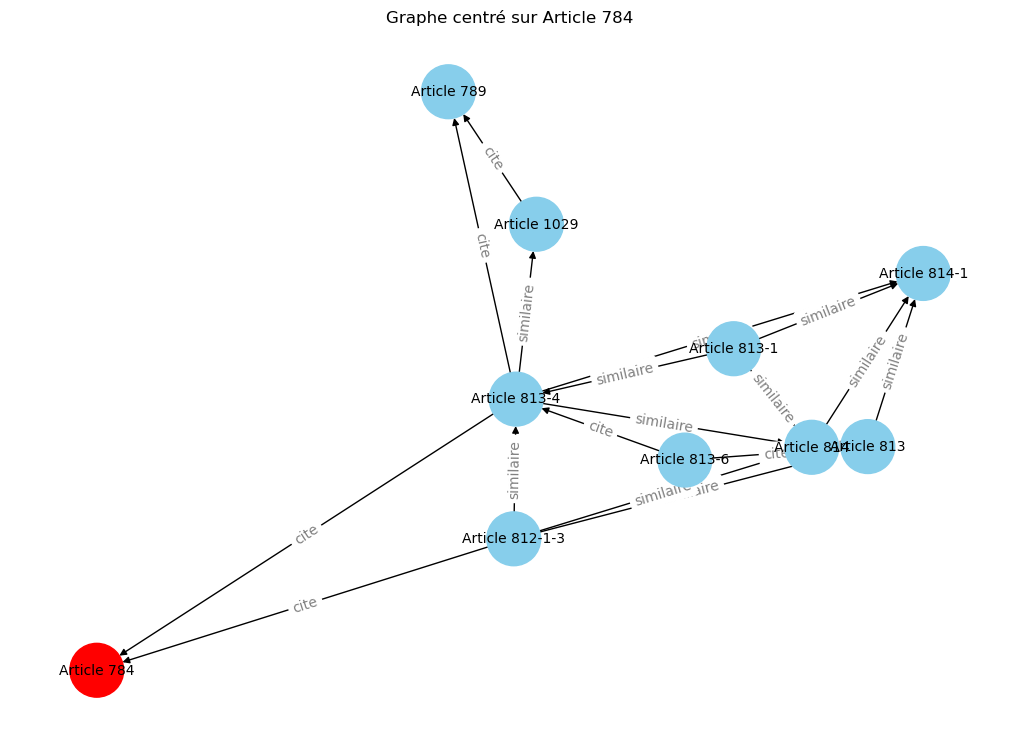

In [64]:
visualize_article_graph(G, "Article 784", depth=2)


# Langchain/Langraph

In [ ]:
class GraphState(TypedDict):
    question: str
    documents: List[Document]
    answer: str




In [ ]:
def expand_from_graph(G, seed_titles, hops=2):
    visited = set(seed_titles)
    frontier = set(seed_titles)

    for _ in range(hops):
        new_nodes = set()
        for node in frontier:
            new_nodes.update(G.successors(node))
            new_nodes.update(G.predecessors(node))
        new_nodes -= visited
        visited |= new_nodes
        frontier = new_nodes

    return list(visited)


In [ ]:
embedding_model = HuggingFaceEmbeddings(
    model_name="sentence-transformers/all-MiniLM-L6-v2"
)

documents = [
    Document(
        page_content=a["content"],
        metadata={"title": a["title"]}
    )
    for a in all_articles
]

vectorstore = FAISS.from_documents(documents, embedding_model)
retriever = vectorstore.as_retriever(search_kwargs={"k": 5})


In [ ]:
def graph_rag_retrieve(state: GraphState):
    # 1. Recherche vectorielle (seed)
    seed_docs = retriever.invoke(state["question"])
    seed_titles = [d.metadata["title"] for d in seed_docs]

    # 2. Expansion via le graphe
    expanded_titles = expand_from_graph(G, seed_titles, hops=2)

    # 3. Reconstruction du sous-graphe documentaire
    final_docs = [
        Document(
            page_content=a["content"],
            metadata={"title": a["title"]}
        )
        for a in all_articles
        if a["title"] in expanded_titles
    ]

    return {"documents": final_docs}


In [ ]:
def answer_node(state: GraphState):
    context = "\n\n".join(
        f"{d.metadata['title']}:\n{d.page_content}"
        for d in state["documents"]
    )

    prompt = f"""
Tu es un assistant juridique expert en droit civil français.
Réponds STRICTEMENT à partir des articles ci-dessous.

{context}

Question : {state['question']}

Réponse :
"""

    answer = generate_answer(prompt)
    return {"answer": answer}


In [ ]:
graph = StateGraph(GraphState)

graph.add_node("graph_rag", graph_rag_retrieve)
graph.add_node("answer", answer_node)

graph.set_entry_point("graph_rag")
graph.add_edge("graph_rag", "answer")

app = graph.compile()


In [ ]:
result = app.invoke({
    "question": "Qu’est-ce qu’un contrat synallagmatique ?"
})

print("RÉPONSE :\n")
print(result["answer"])

print("\nSOURCES :")
for d in result["documents"]:
    print("-", d.metadata["title"])
